In [1]:
!nvidia-smi -L

GPU 0: NVIDIA GeForce GTX 1080 (UUID: GPU-a1187528-6115-ab79-3545-beef871aae6d)


## Get a text dataset

In [1]:
import zipfile


def unzip_data(filename):
    zip_ref = zipfile.ZipFile(filename, "r")
    zip_ref.extractall()
    zip_ref.close()

In [2]:
import os

file_path = "nlp_getting_started.zip"

if not os.path.exists(file_path):
    !wget https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
else:
    print("File already exists. Skipping download.")
    
unzip_data("nlp_getting_started.zip")

File already exists. Skipping download.


## Visualizing a text dataset

In [3]:
import pandas as pd

train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
train_df["text"][:10]

0    Our Deeds are the Reason of this #earthquake M...
1               Forest fire near La Ronge Sask. Canada
2    All residents asked to 'shelter in place' are ...
3    13,000 people receive #wildfires evacuation or...
4    Just got sent this photo from Ruby #Alaska as ...
5    #RockyFire Update => California Hwy. 20 closed...
6    #flood #disaster Heavy rain causes flash flood...
7    I'm on top of the hill and I can see a fire in...
8    There's an emergency evacuation happening now ...
9    I'm afraid that the tornado is coming to our a...
Name: text, dtype: object

In [5]:
# Shuffle training dataframe
train_df_shuffled = train_df.sample(frac=1, random_state=42)
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [6]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [7]:
train_df.target.value_counts()

target
0    4342
1    3271
Name: count, dtype: int64

In [8]:
len(train_df), len(test_df)

(7613, 3263)

In [9]:
import random

random_index = random.randint(
    0, len(train_df) - 5
)  # Create random indexes not higher than the total number of samples
for row in train_df_shuffled[["text", "target"]][
    random_index : random_index + 5
].itertuples():
    _, text, target = row
    print(f"Target {target}", "(real disaster)" if target > 0 else "(not real diaster)")
    print(f"Text:\n{text}\n")
    print(f"---\n")

Target 0 (not real diaster)
Text:
that horrible sinking feeling when youÛªve been at home on your phone for a while and you realise its been on 3G this whole time

---

Target 0 (not real diaster)
Text:
@estellasrevenge the first time i went swiming in it i was basically screaming WHY DOES IT SMELL/TASTE SO BAD

---

Target 1 (real disaster)
Text:
1.94 earthquake occurred 5km S of Volcano Hawaii at 01:04 UTC! #earthquake #Volcano http://t.co/auf4J4Owj1

---

Target 0 (not real diaster)
Text:
#hot  Funtenna: hijacking computers to send data as sound waves [Black Hat 2015] http://t.co/MIs0RjxuIr #prebreak #best

---

Target 0 (not real diaster)
Text:
@Blizzard_draco @LoneWolffur I need this.

---



### Split data into trianing and validation sets

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
train_sentences, val_sentences, train_labels, val_labels = train_test_split(
    train_df_shuffled["text"].to_numpy(),
    train_df_shuffled["target"].to_numpy(),
    test_size=0.1,
    random_state=42,
)

In [12]:
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)

(6851, 6851, 762, 762)

In [13]:
train_sentences[:10], train_labels[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object),
 array([0,

## Text vectorization (tokenization)

In [14]:
import tensorflow as tf

print(tf.__version__)

2024-04-16 10:15:55.898733: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-16 10:15:55.898769: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-16 10:15:55.899704: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-16 10:15:55.907721: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-16 10:15:57.265578: W tensorflow/compiler/tf2

2.15.0


In [15]:
from tensorflow.keras.layers import TextVectorization

text_vectorizer = TextVectorization(
    max_tokens=None,
    standardize="lower_and_strip_punctuation",
    split="whitespace",
    ngrams=None,
    output_mode="int",  # how to map tokens to numebers
    output_sequence_length=None,
)

2024-04-16 10:15:59.235450: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-16 10:15:59.300889: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-16 10:15:59.301210: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [19]:
# Find average number of tokens
round(sum([len(i.split()) for i in train_sentences]) / len(train_sentences))

15

In [20]:
# Setup text vectorization with custom variables
max_vocab_length = 10000
max_length = 15

text_vectorizer = TextVectorization(
    max_tokens=max_vocab_length, output_sequence_length=max_length
)

In [21]:
# Fit the text vectorizer to the training text
text_vectorizer.adapt(train_sentences)

In [22]:
sample_sentence = "There's a Wall Street!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[ 264,    3, 1104,  698,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0]])>

In [23]:
# Chose a random sentence from training dataset and tokenize it
random_sentence = random.choice(train_sentences)
print(
    f"Original text:\n{random_sentence}\
\n\nVectorized version:\n {text_vectorizer([random_sentence])}"
)

Original text:
@Calum5SOS you look like you got caught in a rainstorm this is amazing and disgusting at the same time

Vectorized version:
 [[4041   12  173   25   12  100  787    4    3  569   19    9 1720    7
  3922]]


In [24]:
# Get the unique words in the vocab
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5]
bottom_5_words = words_in_vocab[-5:]
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"Top 5 most common words: {top_5_words}")
print(f"Bottom 5 least common words: {bottom_5_words}")

Number of words in vocab: 10000
Top 5 most common words: ['', '[UNK]', 'the', 'a', 'in']
Bottom 5 least common words: ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


In [25]:
tf.random.set_seed(42)
from tensorflow.keras import layers

embedding = layers.Embedding(
    input_dim=max_vocab_length,
    output_dim=128,
    embeddings_initializer="uniform",
    name="embedding_1",
)
embedding

In [26]:
random_sentence = random.choice(train_sentences)
print(f"Original first word from sentence: {random_sentence}")
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original first word from sentence: @BlizzHeroes @DustinBrowder DAD. I won't chase you constantly &amp; all the time but frequently. With a great deal of danger and distraction &lt;3


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[-0.03763726, -0.02015004,  0.00520952, ...,  0.02468605,
         -0.01721723, -0.04515164],
        [-0.04087514, -0.02329108, -0.01362247, ...,  0.00208452,
         -0.02546431,  0.01796801],
        [ 0.00565625, -0.00428062, -0.03432222, ...,  0.02695452,
          0.00784794,  0.03720452],
        ...,
        [-0.00783715, -0.02900138, -0.03782851, ..., -0.02145433,
          0.03058304, -0.03620807],
        [-0.04087514, -0.02329108, -0.01362247, ...,  0.00208452,
         -0.02546431,  0.01796801],
        [-0.01221849,  0.00130379,  0.02888766, ...,  0.0188339 ,
          0.0045688 , -0.03141739]]], dtype=float32)>

In [27]:
sample_embed[0][0]

<tf.Tensor: shape=(128,), dtype=float32, numpy=
array([-0.03763726, -0.02015004,  0.00520952, -0.03197598, -0.03658258,
       -0.03981912, -0.03156602, -0.01381592, -0.03949923, -0.01023819,
        0.04726363,  0.03394487, -0.0053898 , -0.02471805, -0.02281961,
        0.00014651,  0.008876  ,  0.01168151, -0.03040138,  0.03504808,
        0.01797957,  0.03872043, -0.0485431 ,  0.03434079,  0.00947722,
       -0.01595157,  0.01167958, -0.00928041, -0.02126588, -0.02162381,
        0.02210578,  0.00069805, -0.00431512,  0.03560318, -0.01901262,
       -0.02761686, -0.04276831,  0.04684548,  0.01312507, -0.01981262,
       -0.0488973 , -0.02883295,  0.0363446 , -0.0102361 , -0.0342512 ,
        0.03234588,  0.0162021 , -0.00801494,  0.01778287,  0.02458696,
        0.02644062,  0.04615109, -0.00138992,  0.04435216, -0.00623176,
        0.01998614, -0.01359203, -0.04378241, -0.01705138,  0.04632351,
        0.03182716,  0.01820851,  0.01184608, -0.03304292,  0.00589869,
        0.049171

In [28]:
len(sample_embed[0][0])

128

### Following models:
* Model 0: Naive Bayes (baseline)
* Model 1: Feed-forward neural network (dense model)
* Model 2: LSTM model
* Model 3: GRU model
* Model 4: Bidirectional-LSTM model
* Model 5: 1D Convolutional Neural Network
* Model 6: TensorFlow Hub Pretrained Feature Extractor
* Model 7: Same as model 6 with 10% of training data

### Each experiment will go through the following steps:
* Construct the model
* Train the model
* Make predictions with the model
* Track prediction evaluation metrics for later comparison

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline(
    [
        ("tfidf", TfidfVectorizer()),  # convert words to numbers using tfidf
        ("clf", MultinomialNB()),  # model the text
    ]
)

model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [30]:
baseline_score = model_0.score(val_sentences, val_labels)
print(f"Our baseline model achieves an accuracy of: {baseline_score*100:.2f}%")

Our baseline model achieves an accuracy of: 79.27%


In [31]:
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

In [32]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support


def calculate_results(y_true, y_pred):
    """
    Calculates model accuracy, precision, recall and f1 score of a binary classification model.
      Args:
      y_true = true labels in the form of a 1D array
      y_pred = predicted labels in the form of a 1D array

      Return a dictionary of accuracy, precision, recall, f1-score.
    """
    model_accuracy = accuracy_score(y_true, y_pred) * 100
    model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="weighted"
    )
    model_results = {
        "accuracy": model_accuracy,
        "precision": model_precision,
        "recall": model_recall,
        "f1": model_f1,
    }
    return model_results

In [33]:
baseline_results = calculate_results(y_true=val_labels, y_pred=baseline_preds)
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

In [34]:
from helper_functions import create_tensorboard_callback

SAVE_DIR = "model_logs"

In [35]:
from tensorflow.keras import layers

inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_1 = tf.keras.Model(inputs, outputs, name="model_1_dense")

In [36]:
model_1.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"],
)

In [37]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_2 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1280129 (4.88 MB)
Trainable params: 128

In [38]:
model_1_history = model_1.fit(
    train_sentences,
    train_labels,
    epochs=5,
    validation_data=(val_sentences, val_labels),
    callbacks=[
        create_tensorboard_callback(
            dir_name=SAVE_DIR, experiment_name="simple_dense_model"
        )
    ],
)

Saving TensorBoard log files to: model_logs/simple_dense_model/20240416-101650
Epoch 1/5


2024-04-16 10:16:52.806952: I external/local_xla/xla/service/service.cc:168] XLA service 0x78bcbc11b260 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-16 10:16:52.807041: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1080, Compute Capability 6.1
2024-04-16 10:16:52.811777: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-16 10:16:53.373663: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
I0000 00:00:1713255413.457526   12625 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


215/215 [==============================] - 9s 29ms/step - loss: 0.6111 - accuracy: 0.6922 - val_loss: 0.5373 - val_accuracy: 0.7572
Epoch 2/5
215/215 [==============================] - 2s 7ms/step - loss: 0.4424 - accuracy: 0.8184 - val_loss: 0.4694 - val_accuracy: 0.7861
Epoch 3/5
215/215 [==============================] - 1s 6ms/step - loss: 0.3473 - accuracy: 0.8610 - val_loss: 0.4591 - val_accuracy: 0.7887
Epoch 4/5
215/215 [==============================] - 1s 5ms/step - loss: 0.2857 - accuracy: 0.8918 - val_loss: 0.4641 - val_accuracy: 0.7874
Epoch 5/5
215/215 [==============================] - 1s 5ms/step - loss: 0.2388 - accuracy: 0.9117 - val_loss: 0.4766 - val_accuracy: 0.7861


In [39]:
model_1.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 2ms/step - loss: 0.4766 - accuracy: 0.7861


[0.4766428470611572, 0.7860892415046692]

In [40]:
embedding.weights

[<tf.Variable 'embedding_1/embeddings:0' shape=(10000, 128) dtype=float32, numpy=
 array([[-0.04868212,  0.01070408, -0.00851323, ...,  0.02037134,
          0.00877138, -0.01344865],
        [-0.03806128, -0.02341271, -0.01179755, ...,  0.00064543,
         -0.03068794,  0.01848759],
        [-0.03238319, -0.06832341, -0.01025042, ...,  0.02692684,
          0.05070784, -0.05510851],
        ...,
        [ 0.02559224, -0.03650941, -0.04243267, ...,  0.03197311,
         -0.03459262, -0.04102521],
        [-0.07016151, -0.08019362,  0.00441922, ...,  0.08046782,
          0.06043225, -0.03244568],
        [-0.02693974, -0.06775773, -0.06613138, ...,  0.02329042,
          0.04525489, -0.08346458]], dtype=float32)>]

In [41]:
embed_weights = model_1.get_layer("embedding_1").get_weights()[0]
print(embed_weights.shape)

(10000, 128)


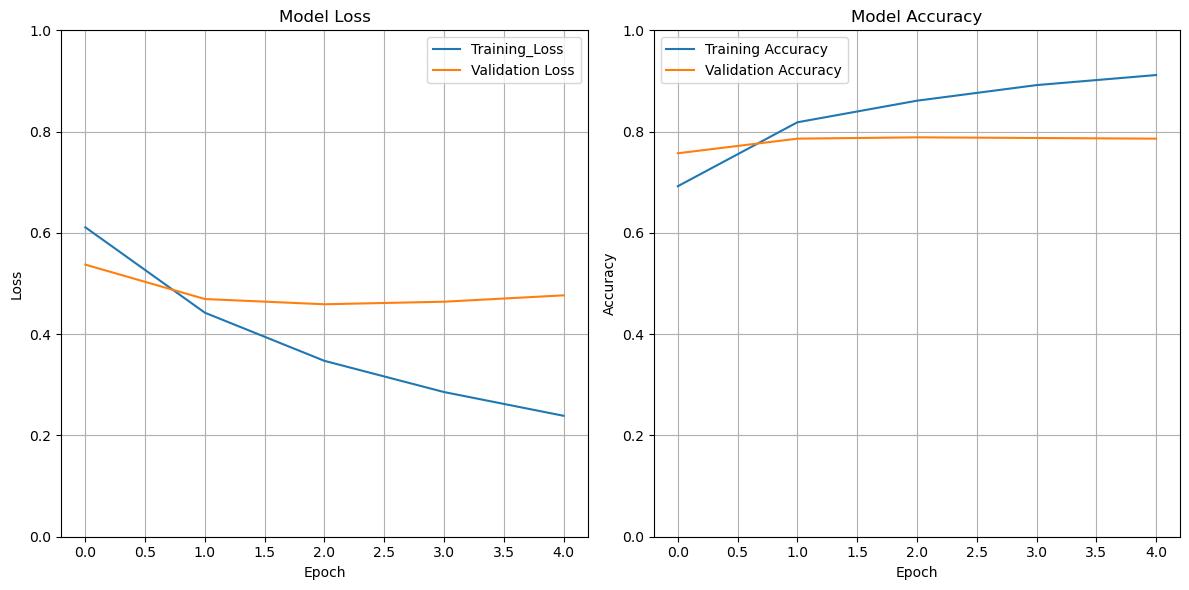

In [42]:
import matplotlib.pyplot as plt


def plot_training_history(model_history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    ax1.plot(model_history.history["loss"], label="Training_Loss")
    ax1.plot(model_history.history["val_loss"], label="Validation Loss")
    ax1.set_title("Model Loss")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.grid()
    ax1.legend()
    ax1.set_ylim(0, 1)

    ax2.plot(model_history.history["accuracy"], label="Training Accuracy")
    ax2.plot(model_history.history["val_accuracy"], label="Validation Accuracy")
    ax2.set_title("Model Accuracy")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Accuracy")
    ax2.grid()
    ax2.legend()
    ax2.set_ylim(0, 1)

    plt.tight_layout()
    plt.show()


plot_training_history(model_history=model_1_history)

In [43]:
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs[:10]

24/24 [==============================] - 0s 1ms/step


array([[0.4034343 ],
       [0.7450646 ],
       [0.99795413],
       [0.10680999],
       [0.11098234],
       [0.93438786],
       [0.9088428 ],
       [0.99249953],
       [0.96823287],
       [0.2594916 ]], dtype=float32)

In [44]:
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs))
model_1_preds[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1.], dtype=float32)>

In [45]:
model_1_results = calculate_results(y_true=val_labels, y_pred=model_1_preds)
model_1_results

{'accuracy': 78.60892388451444,
 'precision': 0.7903277546022673,
 'recall': 0.7860892388451444,
 'f1': 0.7832971347503846}

In [46]:
import numpy as np

np.array(list(model_1_results.values())) > np.array(list(baseline_results.values()))

array([False, False, False, False])

In [47]:
def compare_baseline_to_new_results(baseline_results, new_model_results):
    for key, value in baseline_results.items():
        print(
            f"Baseline {key}: {value:.2f}, New {key}: {new_model_results[key]:.2f}, Difference: {new_model_results[key]-value:.2f}"
        )


compare_baseline_to_new_results(
    baseline_results=baseline_results, new_model_results=model_1_results
)

Baseline accuracy: 79.27, New accuracy: 78.61, Difference: -0.66
Baseline precision: 0.81, New precision: 0.79, Difference: -0.02
Baseline recall: 0.79, New recall: 0.79, Difference: -0.01
Baseline f1: 0.79, New f1: 0.78, Difference: -0.00


In [48]:
# Get the vocabulary from the text vectorization layer
words_in_vocab = text_vectorizer.get_vocabulary()
len(words_in_vocab), words_in_vocab[:10]

(10000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'])

In [49]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_2 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1280129 (4.88 MB)
Trainable params: 128

In [50]:
# Get the weight matrix of mebedding layer
# (these are the numerical patterns between the text in the training dataset the model has learned)
embed_weights = model_1.get_layer("embedding_1").get_weights()[0]
print(embed_weights.shape)

(10000, 128)


In [51]:
tf.random.set_seed(42)
from tensorflow.keras import layers

model_2_embedding = layers.Embedding(
    input_dim=max_vocab_length,
    output_dim=128,
    embeddings_initializer="uniform",
    name="embedding_2",
)
# LSTM model
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_2_embedding(x)
print(x.shape)
x = layers.LSTM(64)(x)
print(x.shape)
x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2_LSTM")

(None, 15, 128)
(None, 64)


In [52]:
model_2.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"],
)

In [53]:
model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_2 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding_2 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                      

In [ ]:
model_2_history = model_2.fit(
    train_sentences,
    train_labels,
    epochs=5,
    validation_data=(val_sentences, val_labels),
    callbacks=[create_tensorboard_callback(SAVE_DIR, "LSTM")],
)

Saving TensorBoard log files to: model_logs/LSTM/20240416-101713
Epoch 1/5
110/215 [==============>...............] - ETA: 3s - loss: 0.5689 - accuracy: 0.6918

In [53]:
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs.shape, model_2_pred_probs[:10]

24/24 [==============================] - 0s 3ms/step


((762, 1),
 array([[0.00470405],
        [0.69837475],
        [0.9995722 ],
        [0.04463159],
        [0.00144312],
        [0.999597  ],
        [0.9120018 ],
        [0.99991524],
        [0.9997677 ],
        [0.31496775]], dtype=float32))

In [54]:
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [55]:
model_2_results = calculate_results(y_true=val_labels, y_pred=model_2_preds)
model_2_results

{'accuracy': 76.50918635170603,
 'precision': 0.7681519700378248,
 'recall': 0.7650918635170604,
 'f1': 0.7621795783524195}

In [56]:
compare_baseline_to_new_results(baseline_results, model_2_results)

Baseline accuracy: 79.27, New accuracy: 76.51, Difference: -2.76
Baseline precision: 0.81, New precision: 0.77, Difference: -0.04
Baseline recall: 0.79, New recall: 0.77, Difference: -0.03
Baseline f1: 0.79, New f1: 0.76, Difference: -0.02


In [57]:
# GRU model
tf.random.set_seed(42)
from tensorflow.keras import layers

model_3_embedding = layers.Embedding(
    input_dim=max_vocab_length,
    output_dim=128,
    embeddings_initializer="uniform",
    name="embedding_3",
)

inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_3_embedding(x)
x = layers.GRU(64)(x)
x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_GRU")

In [58]:
model_3.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"],
)

In [59]:
model_3.summary()

Model: "model_3_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding_3 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 gru (GRU)                   (None, 64)                37248     
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                       

In [60]:
model_3_history = model_3.fit(
    train_sentences,
    train_labels,
    epochs=5,
    validation_data=(val_sentences, val_labels),
    callbacks=[create_tensorboard_callback(SAVE_DIR, "GRU")],
)

Saving TensorBoard log files to: model_logs/GRU/20240416-095237
Epoch 1/5
215/215 [==============================] - 9s 30ms/step - loss: 0.5293 - accuracy: 0.7266 - val_loss: 0.4544 - val_accuracy: 0.7769
Epoch 2/5
215/215 [==============================] - 2s 8ms/step - loss: 0.3219 - accuracy: 0.8686 - val_loss: 0.4974 - val_accuracy: 0.7795
Epoch 3/5
215/215 [==============================] - 1s 7ms/step - loss: 0.2199 - accuracy: 0.9159 - val_loss: 0.5534 - val_accuracy: 0.7690
Epoch 4/5
215/215 [==============================] - 1s 6ms/step - loss: 0.1564 - accuracy: 0.9442 - val_loss: 0.6592 - val_accuracy: 0.7822
Epoch 5/5
215/215 [==============================] - 1s 7ms/step - loss: 0.1165 - accuracy: 0.9584 - val_loss: 0.6654 - val_accuracy: 0.7677


In [61]:
model_3_pred_probs = model_3.predict(val_sentences)
model_3_pred_probs.shape, model_3_pred_probs[:10]

24/24 [==============================] - 0s 2ms/step


((762, 1),
 array([[0.25789255],
        [0.89478046],
        [0.9991974 ],
        [0.09990485],
        [0.012717  ],
        [0.997912  ],
        [0.51596457],
        [0.99935836],
        [0.99895585],
        [0.70050883]], dtype=float32))

In [62]:
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [63]:
model_3_results = calculate_results(y_true=val_labels, y_pred=model_3_preds)
model_3_results

{'accuracy': 76.77165354330708,
 'precision': 0.7673454393039123,
 'recall': 0.7677165354330708,
 'f1': 0.7671452951501907}

In [64]:
compare_baseline_to_new_results(baseline_results, model_3_results)

Baseline accuracy: 79.27, New accuracy: 76.77, Difference: -2.49
Baseline precision: 0.81, New precision: 0.77, Difference: -0.04
Baseline recall: 0.79, New recall: 0.77, Difference: -0.02
Baseline f1: 0.79, New f1: 0.77, Difference: -0.02


In [65]:
# Bidirectional model
tf.random.set_seed(42)
from tensorflow.keras import layers

model_4_embedding = layers.Embedding(
    input_dim=max_vocab_length,
    output_dim=128,
    embeddings_initializer="uniform",
    name="embedding_4",
)

inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_4_embedding(x)
x = layers.Bidirectional(layers.LSTM(64))(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_4 = tf.keras.Model(inputs, outputs, name="model_4_Bidirectional")

In [66]:
model_4.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"],
)

In [67]:
model_4.summary()

Model: "model_4_Bidirectional"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding_4 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 bidirectional (Bidirection  (None, 128)               98816     
 al)                                                             
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1378945 (5.26 MB)
Trainable par

In [68]:
model_4_history = model_4.fit(
    train_sentences,
    train_labels,
    epochs=5,
    validation_data=(val_sentences, val_labels),
    callbacks=[create_tensorboard_callback(SAVE_DIR, "bidirectional_RNN")],
)

Saving TensorBoard log files to: model_logs/bidirectional_RNN/20240416-095253
Epoch 1/5
215/215 [==============================] - 9s 29ms/step - loss: 0.5106 - accuracy: 0.7443 - val_loss: 0.4623 - val_accuracy: 0.7717
Epoch 2/5
215/215 [==============================] - 2s 9ms/step - loss: 0.3133 - accuracy: 0.8713 - val_loss: 0.5161 - val_accuracy: 0.7717
Epoch 3/5
215/215 [==============================] - 2s 8ms/step - loss: 0.2123 - accuracy: 0.9194 - val_loss: 0.5575 - val_accuracy: 0.7717
Epoch 4/5
215/215 [==============================] - 2s 7ms/step - loss: 0.1447 - accuracy: 0.9533 - val_loss: 0.6603 - val_accuracy: 0.7743
Epoch 5/5
215/215 [==============================] - 2s 8ms/step - loss: 0.1020 - accuracy: 0.9667 - val_loss: 0.7410 - val_accuracy: 0.7585


In [69]:
model_4_pred_probs = model_4.predict(val_sentences)
model_4_pred_probs[:10]

24/24 [==============================] - 1s 3ms/step


array([[0.04523894],
       [0.91637194],
       [0.9996737 ],
       [0.20119122],
       [0.0065169 ],
       [0.99795026],
       [0.99321896],
       [0.9998437 ],
       [0.99976784],
       [0.2583552 ]], dtype=float32)

In [70]:
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [71]:
model_4_results = calculate_results(val_labels, model_4_preds)
model_4_results

{'accuracy': 75.8530183727034,
 'precision': 0.7581222241586,
 'recall': 0.7585301837270341,
 'f1': 0.7581368118458878}

In [72]:
compare_baseline_to_new_results(baseline_results, model_4_results)

Baseline accuracy: 79.27, New accuracy: 75.85, Difference: -3.41
Baseline precision: 0.81, New precision: 0.76, Difference: -0.05
Baseline recall: 0.79, New recall: 0.76, Difference: -0.03
Baseline f1: 0.79, New f1: 0.76, Difference: -0.03


In [76]:
# Test out the embedding, 1D convolutional and max pooling
embedding_test = embedding(text_vectorizer(["this is a test sentence"]))
conv_1d = layers.Conv1D(filters=32, kernel_size=5, activation="relu")
conv_1d_output = conv_1d(embedding_test)
max_pool = layers.GlobalMaxPool1D()
max_pool_output = max_pool(conv_1d_output)
embedding_test.shape, conv_1d_output.shape, max_pool_output.shape

In [77]:
# Conv1D model
tf.random.set_seed(42)
from tensorflow.keras import layers

model_5_embedding = layers.Embedding(
    input_dim=max_vocab_length,
    output_dim=128,
    embeddings_initializer="uniform",
    name="embedding_5",
)

inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_5_embedding(x)
x = layers.Conv1D(filters=32, kernel_size=5, activation="relu")(x)
x = layers.GlobalMaxPool1D()(x)
x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_5 = tf.keras.Model(inputs, outputs, name="model_5_Conv1D")

model_5.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"],
)

model_5.summary()

Model: "model_5_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding_5 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 conv1d_1 (Conv1D)           (None, 11, 32)            20512     
                                                                 
 global_max_pooling1d (Glob  (None, 32)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense_6 (Dense)             (None, 64)             

In [78]:
model_5_history = model_5.fit(
    train_sentences,
    train_labels,
    epochs=5,
    validation_data=(val_sentences, val_labels),
    callbacks=[create_tensorboard_callback(SAVE_DIR, "Conv1D")],
)

Saving TensorBoard log files to: model_logs/Conv1D/20240416-095659
Epoch 1/5


2024-04-16 09:56:59.882504: W tensorflow/core/kernels/conv_ops_gpu.cc:322] None of the algorithms provided by cuDNN frontend heuristics worked; trying fallback algorithms.  Conv: batch: 32
in_depths: 128
out_depths: 32
in: 1
in: 15
data_format: 1
filter: 1
filter: 5
filter: 128
dilation: 1
dilation: 1
stride: 1
stride: 1
padding: 0
padding: 0
dtype: DT_FLOAT
group_count: 1
device_identifier: "sm_6.1 with 8504934400B RAM, 20 cores, 1733500KHz clock, 5005000KHz mem clock, 2097152B L2$"
version: 3

2024-04-16 09:56:59.884190: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at conv_ops_impl.h:1199 : NOT_FOUND: No algorithm worked!  Error messages:
  Profiling failure on CUDNN engine eng1{}: UNKNOWN: CUDNN_STATUS_ALLOC_FAILED
in external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc(6808): 'status'
  Profiling failure on CUDNN engine eng28{}: UNKNOWN: CUDNN_STATUS_ALLOC_FAILED
in external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc(6808): 'status'
  Profiling failure o

NotFoundError: Graph execution error:

Detected at node model_5_Conv1D/conv1d_1/Conv1D defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/home/kajetan/anaconda3/lib/python3.11/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/kajetan/anaconda3/lib/python3.11/site-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/home/kajetan/anaconda3/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 736, in start

  File "/home/kajetan/anaconda3/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/kajetan/anaconda3/lib/python3.11/asyncio/base_events.py", line 607, in run_forever

  File "/home/kajetan/anaconda3/lib/python3.11/asyncio/base_events.py", line 1922, in _run_once

  File "/home/kajetan/anaconda3/lib/python3.11/asyncio/events.py", line 80, in _run

  File "/home/kajetan/anaconda3/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 516, in dispatch_queue

  File "/home/kajetan/anaconda3/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 505, in process_one

  File "/home/kajetan/anaconda3/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 412, in dispatch_shell

  File "/home/kajetan/anaconda3/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 740, in execute_request

  File "/home/kajetan/anaconda3/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 422, in do_execute

  File "/home/kajetan/anaconda3/lib/python3.11/site-packages/ipykernel/zmqshell.py", line 546, in run_cell

  File "/home/kajetan/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3024, in run_cell

  File "/home/kajetan/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3079, in _run_cell

  File "/home/kajetan/anaconda3/lib/python3.11/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/home/kajetan/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3284, in run_cell_async

  File "/home/kajetan/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3466, in run_ast_nodes

  File "/home/kajetan/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3526, in run_code

  File "/tmp/ipykernel_5899/848493418.py", line 1, in <module>

  File "/home/kajetan/anaconda3/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/kajetan/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 1807, in fit

  File "/home/kajetan/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/home/kajetan/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/home/kajetan/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/home/kajetan/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 1150, in train_step

  File "/home/kajetan/anaconda3/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/kajetan/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 590, in __call__

  File "/home/kajetan/anaconda3/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/kajetan/anaconda3/lib/python3.11/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/home/kajetan/anaconda3/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/home/kajetan/anaconda3/lib/python3.11/site-packages/keras/src/engine/functional.py", line 515, in call

  File "/home/kajetan/anaconda3/lib/python3.11/site-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/home/kajetan/anaconda3/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/kajetan/anaconda3/lib/python3.11/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/home/kajetan/anaconda3/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/home/kajetan/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py", line 290, in call

  File "/home/kajetan/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py", line 262, in convolution_op

No algorithm worked!  Error messages:
  Profiling failure on CUDNN engine eng1{}: UNKNOWN: CUDNN_STATUS_ALLOC_FAILED
in external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc(6808): 'status'
  Profiling failure on CUDNN engine eng28{}: UNKNOWN: CUDNN_STATUS_ALLOC_FAILED
in external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc(6808): 'status'
  Profiling failure on CUDNN engine eng0{}: UNKNOWN: CUDNN_STATUS_ALLOC_FAILED
in external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc(6808): 'status'
  Profiling failure on CUDNN engine eng42{k2=0,k4=1,k5=1,k6=0,k7=0}: UNKNOWN: CUDNN_STATUS_EXECUTION_FAILED
in external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc(6808): 'status'
  Profiling failure on CUDNN engine eng28{k2=1,k3=0}: UNKNOWN: CUDNN_STATUS_ALLOC_FAILED
in external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc(6808): 'status'
	 [[{{node model_5_Conv1D/conv1d_1/Conv1D}}]] [Op:__inference_train_function_51280]

In [ ]:
model_5_pred_probs = model_5.predict(val_sentences)
model_5_pred_probs[:10]

In [ ]:
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_preds[:10]

In [ ]:
model_5_results = calculate_results(y_true=val_labels, y_pred=model_5_preds)
model_5_results

In [ ]:
compare_baseline_to_new_results(baseline_results, model_5_results)

In [79]:
import tensorflow_hub as hub

print("tensorflow:", tf.__version__)
print("tensorflow hub:", hub.__version__)

tensorflow: 2.15.0
tensorflow hub: 0.15.0


In [90]:
import tensorflow as tf
import tensorflow_hub as hub

class USELayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(USELayer, self).__init__(**kwargs)
        self.use_embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

    def call(self, inputs):
        return self.use_embed(inputs)

    def get_config(self):
        config = super(USELayer, self).get_config()
        return config


tf.keras.utils.register_keras_serializable("USELayer", USELayer)

# Define input layer
input_layer = layers.Input(shape=[], dtype=tf.string, name="input_layer")
# Apply the custom layer to the input
use_embedding = USELayer()(input_layer)
# Define the remaining layers of the model
dense_1 = layers.Dense(64, activation="relu")(use_embedding)
output = layers.Dense(1, activation="sigmoid")(dense_1)

# Create the model
model_6 = Model(inputs=input_layer, outputs=output, name="model_6_USE")

# Compile model
model_6.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"],
)

In [91]:
model_6_history = model_6.fit(
    train_sentences,
    train_labels,
    epochs=5,
    validation_data=(val_sentences, val_labels),
    callbacks=[create_tensorboard_callback(SAVE_DIR, "tf_hub_sentence_encoder")],
)

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder/20240416-101047
Epoch 1/5
215/215 [==============================] - 5s 10ms/step - loss: 0.5036 - accuracy: 0.7913 - val_loss: 0.4494 - val_accuracy: 0.8005
Epoch 2/5
215/215 [==============================] - 2s 10ms/step - loss: 0.4155 - accuracy: 0.8139 - val_loss: 0.4392 - val_accuracy: 0.8110
Epoch 3/5
215/215 [==============================] - 2s 10ms/step - loss: 0.4013 - accuracy: 0.8212 - val_loss: 0.4357 - val_accuracy: 0.8150
Epoch 4/5
215/215 [==============================] - 2s 9ms/step - loss: 0.3944 - accuracy: 0.8276 - val_loss: 0.4311 - val_accuracy: 0.8110
Epoch 5/5
215/215 [==============================] - 2s 9ms/step - loss: 0.3886 - accuracy: 0.8270 - val_loss: 0.4329 - val_accuracy: 0.8150


In [ ]:
model_6_pred_probs = model_6.predict(val_sentences)
model_6_pred_probs[:10]

In [ ]:
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_preds[:10]

In [ ]:
model_6_results = calculate_results(val_labels, model_6_preds)
model_6_results

In [ ]:
compare_baseline_to_new_results(baseline_results, model_6_results)

In [ ]:
(
    train_sentences_90_percent,
    train_sentences_10_percent,
    train_labels_90_percent,
    train_labels_10_percent,
) = train_test_split(
    np.array(train_sentences), train_labels, test_size=0.1, random_state=42
)

In [ ]:
print(f"Total training examples: {len(train_sentences)}")
print(f"Length of 10%  training examples: {len(train_sentences_10_percent)}")

In [ ]:
# Check the number of targets in subnet data
pd.Series(train_labels_10_percent).value_counts()

In [89]:
# Clone model_6 but reset weights
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import Model, layers


# Define input layer
input_layer = layers.Input(shape=[], dtype=tf.string, name="input_layer")

# Load Universal Sentence Encoder
use_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
use_embed = hub.load(use_url)


# Define a custom layer to wrap the USE function
class USELayer(layers.Layer):
    def __init__(self, **kwargs):
        super(USELayer, self).__init__(**kwargs)

    def call(self, inputs):
        return use_embed(inputs)


# Apply the custom layer to the input
use_embedding = USELayer()(input_layer)

# Define the remaining layers of the model
dense_1 = layers.Dense(64, activation="relu")(use_embedding)
output = layers.Dense(1, activation="sigmoid")(dense_1)

# Create the model
model_7 = Model(inputs=input_layer, outputs=output, name="model_6_USE")

# Compile model
model_7.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"],
)

TypeError: register_keras_serializable.<locals>.decorator() missing 1 required positional argument: 'arg'

In [ ]:
model_7_history = model_7.fit(
    x=train_sentences_10_percent,
    y=train_labels_10_percent,
    epochs=5,
    validation_data=(val_sentences, val_labels),
    callbacks=[
        create_tensorboard_callback(SAVE_DIR, "10_percent_tf_hub_sentence_encoder")
    ],
)

In [ ]:
model_7_pred_probs = model_7.predict(val_sentences)
model_7_pred_probs[:10]

In [ ]:
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
model_7_preds[:10]

In [ ]:
model_7_results = calculate_results(val_labels, model_7_preds)
model_7_results

In [ ]:
compare_baseline_to_new_results(baseline_results, model_7_results)

In [ ]:
all_model_results = pd.DataFrame(
    {
        "baseline": baseline_results,
        "simple_dense": model_1_results,
        "lstm": model_2_results,
        "gru": model_3_results,
        "bidirectional": model_4_results,
        "conv1d": model_5_results,
        "tf_hub_sentence_encoder": model_6_results,
        "tf_hub_10_percent_data": model_7_results,
    }
)
all_model_results = all_model_results.transpose()
all_model_results

In [ ]:
all_model_results["accuracy"] = all_model_results["accuracy"] / 100

In [ ]:
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

In [ ]:
all_model_results.sort_values("f1", ascending=False)["f1"].plot(
    kind="bar", figsize=(10, 7)
);

In [ ]:
# Get mean pred for 3 models
baseline_pred_probs = np.max(model_0.predict_proba(val_sentences), axis=1)
combined_pred_probs = (
    baseline_pred_probs
    + tf.squeeze(model_2_pred_probs, axis=1)
    + tf.squeeze(model_6_pred_probs)
)
combined_preds = tf.round(combined_pred_probs / 3)
combined_preds[:20]

In [ ]:
ensemble_results = calculate_results(val_labels, combined_preds)
ensemble_results

In [ ]:
all_model_results.loc["ensemble_results"] = ensemble_results

In [ ]:
all_model_results.loc["ensemble_results"]["accuracy"] = (
    all_model_results.loc["ensemble_results"]["accuracy"] / 100
)

In [ ]:
all_model_results

In [87]:
model_6.save("model_6.keras")

In [88]:
loaded_model_5 = tf.keras.models.load_model(
    "model_6.keras", custom_objects={"KerasLayer": hub.KerasLayer}
)

TypeError: Cannot deserialize object of type `USELayer`. If `USELayer` is a custom class, please register it using the `@keras.saving.register_keras_serializable()` decorator.